# Analyse modélisation computer_vision

In [1]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as plty
import plotly.express as px

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps

In [2]:
dataset_global_dir = "./data/dataset_global/"
dataset_photo_dir = "./data/dataset_photo/"
photo_dir = "photos/"

In [3]:
%%time
final_df_photos = pd.read_feather(dataset_global_dir+"/yelp_academic_final_dataset_photo")

CPU times: user 83.5 ms, sys: 38.8 ms, total: 122 ms
Wall time: 136 ms


In [4]:
final_df_photos.head()

,photo_id,label,photo
0,Un_Og6jfhazVn7CxszkKEw,drink,./data/dataset_photo/photos/Un_Og6jfhazVn7Cxsz...
1,BFE1AFOs27scnnfeBf99ZA,drink,./data/dataset_photo/photos/BFE1AFOs27scnnfeBf...
2,7t-C0r1JRdoVD9FS7M-N7Q,drink,./data/dataset_photo/photos/7t-C0r1JRdoVD9FS7M...
3,rLnw0d-YYZvT9kR4y7h7_Q,drink,./data/dataset_photo/photos/rLnw0d-YYZvT9kR4y7...
4,Cv5M8MDw8a5NEWvw2AQ4nw,drink,./data/dataset_photo/photos/Cv5M8MDw8a5NEWvw2A...


In [5]:
final_df_photos["label"].value_counts()

food        39991
menu        39975
drink       39954
interior    39534
outside     39525
Name: label, dtype: int64

In [6]:
list_labels = final_df_photos["label"].value_counts().index.tolist()

In [7]:
def list_photos_by_label_name(df : pd.DataFrame,name : str, sample_size : int = None,random_state : int = 42):
    if sample_size is None:
        return df[df["label"] == name]
    else:
        return df[df["label"] == name].sample(sample_size,random_state=random_state)

all_size = [list_photos_by_label_name(final_df_photos,label).shape[0] for label in list_labels]

min_sample = min(all_size)


food


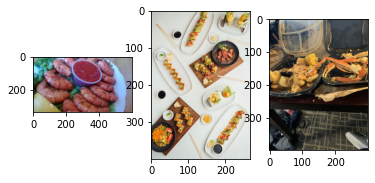

menu


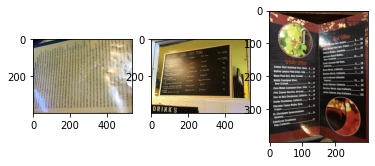

drink


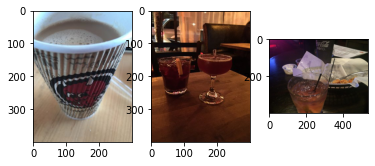

interior


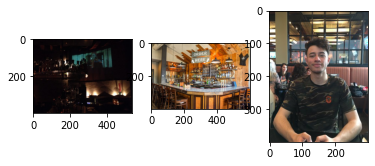

outside


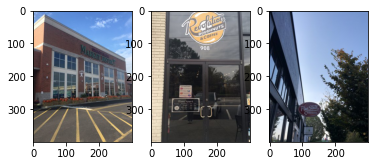

In [8]:
from matplotlib.image import imread

for name in list_labels :
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_photos_by_label_name(final_df_photos,name,min_sample).iloc[i]["photo"]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Test -> SIFT - KMEANS - HIST - CLASSIFIER (modélisation finale avec SIFT)

Cette approche est la finalité de mes recherches, on peut analyser plus loin dans ce document différente approche essayé pour voir la faisabilité et différente approche faite pour cette autoclassification des images.

In [9]:
list_photos = []
list_label = []
for name in list_labels :
    sample_df = list_photos_by_label_name(final_df_photos,name,2500,random_state=0)
    list_photos.extend(sample_df["photo"].tolist())
    list_label.extend(sample_df["label"].tolist())
len(list_photos)

12500

In [10]:
from sklearn.model_selection import train_test_split

list_photo_train,list_photo_test,label_train,label_test = train_test_split(list_photos,
                                                                           list_label,
                                                                           test_size=0.2,
                                                                           random_state=42)
len(list_photo_train)

10000

In [9]:
import pickle
open_classifier = open("./data/pickle/classifier_cv_sift","rb")
best_model = pickle.load(open_classifier)
open_classifier.close()

open_kmeans = open("./data/pickle/kmeans_cv_sift","rb")
kmeans=pickle.load(open_kmeans)
open_kmeans.close()

In [10]:
import cv2
from sklearn.cluster import MiniBatchKMeans
sift = cv2.SIFT_create(500)
def transform_image(img_path : str):
    image = cv2.imread(img_path,0) # convert in gray
    image = cv2.blur(image,(5,5)) # Filter blur image
    res = cv2.equalizeHist(image)   # equalize image histogram
    return sift.detectAndCompute(res, None)

def preprocess_1_image(path):
    _,des = transform_image(path)
    return np.asarray([build_histogram(kmeans,des,0)])

def preprocess_multiple_image(list_path):
    all_hist = []
    for path in list_path:
        _,des = transform_image(path)
        all_hist.append(build_histogram(kmeans,des,0))
    return np.asarray(all_hist)

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des # pondération par rapport au nombre de descripteur
    return hist

In [431]:
import time
sift_keypoints = []
temps1=time.time()
print("Nombre d'image :",len(list_photo_train))
print("Traitement des image et création des descripteurs...")

for image_num in range(len(list_photo_train)) :
    if image_num%(len(list_photo_train)//5) == 0 : print(image_num)
    _,des=transform_image(list_photo_train[image_num])
    sift_keypoints.append(np.asarray(des))

sift_keypoints_by_img = np.asarray(sift_keypoints)
# On aligne les 307 descripteur par image pour faire une liste unique de descripteur
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

Nombre d'image : 10000
Traitement des image et création des descripteurs...
0
2000
4000
6000
8000

Nombre de descripteurs :  (4214122, 128)
temps de traitement SIFT descriptor :           486.06 secondes


In [432]:
temps1=time.time()
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Création de 2053 clusters de descripteurs ...
temps de traitement kmeans :           506.20 secondes


In [433]:
# Creation of histograms (features) (bag of visual words)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des # pondération par rapport au nombre de descripteur
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%500 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
temps de création histogrammes :           214.77 secondes


In [434]:
X_train = im_features
y_train = label_train
X_test = preprocess_multiple_image(list_photo_test)
y_test = label_test

In [476]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=42).fit(X_train,y_train)

In [477]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.5892

In [478]:
f1_score(y_test,y_pred,average="weighted")

0.5827725288897939

In [466]:
pd.DataFrame(confusion_matrix(y_test,y_pred,labels=list_labels),columns=list_labels,index=list_labels)

,food,menu,drink,interior,outside
food,375,5,67,46,23
menu,5,435,14,23,24
drink,160,25,198,81,45
interior,96,12,41,254,91
outside,74,31,39,125,211


In [594]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
Logistic_regression = make_pipeline(StandardScaler(), LogisticRegression(random_state=0))

params = {
        "logisticregression__C":np.logspace(-5, 1, 20),
        "logisticregression__class_weight":[None,'balanced'],
        "logisticregression__max_iter":[200,300,400]
}


In [582]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import time

f1_spec = make_scorer(f1_score,zero_division=1,average="micro")
grid = GridSearchCV(Logistic_regression,params,scoring=f1_spec,cv=5,n_jobs=50)
t0 = time.time()
grid.fit(X_train,y_train)
time_learn = time.time() - t0

In [583]:
print("Temps en seconde d'entrainement :",str(round(time_learn,2))+ "s")
print("Meilleur score :",grid.best_score_)
print("Meilleur params :",grid.best_params_)

Temps en seconde d'entrainement : 604.42s
Meilleur score : 0.6170000000000001
Meilleur params : {'logisticregression__C': 0.00018329807108324357, 'logisticregression__class_weight': 'balanced', 'logisticregression__max_iter': 200}


In [584]:
best_model = grid.best_estimator_

In [585]:
y_pred = best_model.predict(X_test)
pd.DataFrame(confusion_matrix(y_test,y_pred,labels=list_labels),columns=list_labels,index=list_labels)

,food,menu,drink,interior,outside
food,363,1,90,39,23
menu,6,432,21,16,26
drink,118,15,254,78,44
interior,57,6,73,253,105
outside,43,17,51,124,245


In [11]:
def get_classement_classifier_linear(model,X):
    pred = model.predict_proba(X)
    label = model.classes_
    for i in pred.argsort()[0][::-1]:
        print("#"+str(label[i]),":",str(round(pred[0][i]*100,2))+"%")

drink


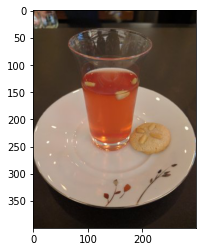


Prediction : ['drink']
Classement :
#drink : 67.87%
#outside : 11.58%
#food : 10.43%
#interior : 7.16%
#menu : 2.96%
CPU times: user 990 ms, sys: 490 ms, total: 1.48 s
Wall time: 174 ms


In [14]:
%%time
photo_n= 10000
path = final_df_photos.iloc[photo_n]["photo"]
label = final_df_photos.iloc[photo_n]["label"]
X_pred = preprocess_1_image(path)
print(label)
img = plt.imread(path)
plt.imshow(img)
plt.show()
print()
print("Prediction :",best_model.predict(X_pred))
print("Classement :")
get_classement_classifier_linear(best_model,X_pred)

In [593]:
# import pickle
# save_classifier = open("./data/pickle/classifier_cv_sift","wb")
# pickle.dump(best_model, save_classifier)
# save_classifier.close()

# save_classifier = open("./data/pickle/kmeans_cv_sift","wb")
# pickle.dump(kmeans, save_classifier)
# save_classifier.close()

# Test -> SIFT - KMEANS - HIST - PCA - TSNE - KMEANS

Test rapide pour voir la faisabilité d'une classificaiton des différrentes image le but ici est de voir si les images sont facilement distinguable par leurs descripteurs respectif (ici assez peu représentatif puisqu'on travail avec un faible jeu de données mais cela donne déjà une bonne idée)

In [199]:
list_photos = []
list_label = []
for name in list_labels :
    sample_df = list_photos_by_label_name(final_df_photos,name,500)
    list_photos.extend(sample_df["photo"].tolist())
    list_label.extend(sample_df["label"].tolist())
len(list_photos)

2500

In [200]:
import cv2
sift = cv2.xfeatures2d.SIFT_create(500)
def transform_image(img_path : str):
    image = cv2.imread(img_path,0) # convert in gray
    image = cv2.blur(image,(5,5)) # Filter blur image
    res = cv2.equalizeHist(image)   # equalize image histogram
    return sift.detectAndCompute(res, None)

In [201]:
import time
sift_keypoints = []
temps1=time.time()
print("Nombre d'image :",len(list_photos))
print("Traitement des image et création des descripteurs...")

for image_num in range(len(list_photos)) :
    if image_num%500 == 0 : print(image_num)
    _,des=transform_image(list_photos[image_num])
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
# On aligne les 307 descripteur par image pour faire une liste unique de descripteur
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

Nombre d'image : 2500
Traitement des image et création des descripteurs...
0
500
1000
1500
2000

Nombre de descripteurs :  (1054393, 128)
temps de traitement SIFT descriptor :            81.52 secondes


In [202]:
from sklearn.cluster import MiniBatchKMeans
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  1027
Création de 1027 clusters de descripteurs ...
temps de traitement kmeans :            51.97 secondes


In [203]:

# Creation of histograms (features) (bag of visual words)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des # pondération par rapport au nombre de descripteur
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%500 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
500
1000
1500
2000
temps de création histogrammes :            40.82 secondes


In [204]:
from sklearn.decomposition import PCA

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (2500, 1027)
Dimensions dataset après réduction PCA :  (2500, 927)


In [228]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = list_label
print(df_tsne.shape)

(2500, 3)


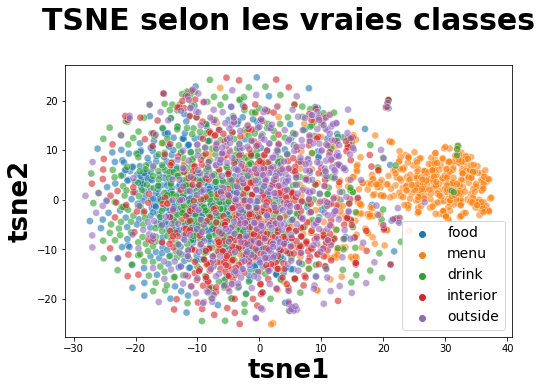

In [229]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

On voit ici que les différentes classes ce distingue suffisament, par example "menu" et totalement bien séparer des autre classse, on retrouve au centre plus vers la droite les images "interior" et "outside", et sur la partie tous à gauche "drink" et "food" (plus sur la partie haute gauche).

Cela peut semblez cohérent avec une réduction de dimension aussi importante, les descripteur similaire ce rejoigne mais des distinction semblent visible. 

> Cette première visualisation nous montre que la classificaiton par les descripteurs SIFT semblent réalisable, jusqu'a un certain niveau d'exigence.

In [230]:
from sklearn import cluster, metrics
n_cluster = len(list_labels)
cls = KMeans(n_clusters=n_cluster, random_state=42)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(2500, 4)


In [231]:
df_tsne["cluster"].value_counts()

2    565
0    515
3    503
4    500
1    417
Name: cluster, dtype: int64

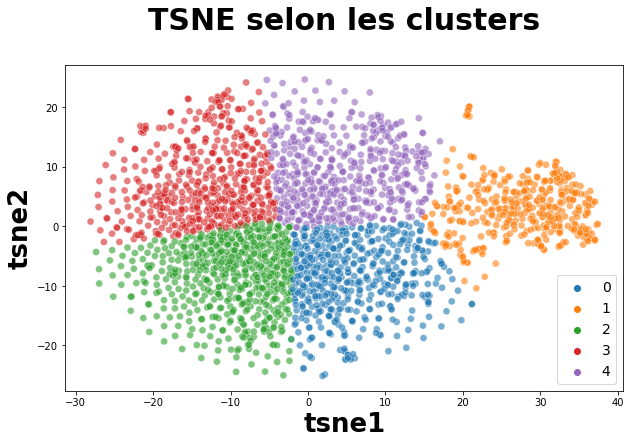

ARI :  0.15164131716903437


In [232]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=n_cluster), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = list_label
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [233]:
df_tsne["class"].value_counts()

food        500
menu        500
drink       500
interior    500
outside     500
Name: class, dtype: int64

In [234]:
match_label = {
    "food":0,
    "menu":1,
    "drink":2,
    "interior":3,
    "outside":4
}
df_tsne["label"] = df_tsne["class"].map(match_label)

In [235]:
labels=df_tsne["label"].values

In [236]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 81   8 176 174  61]
 [ 68 366  10  15  41]
 [ 67  19 151 158 105]
 [165  11 135  78 111]
 [134  13  93  78 182]]


# Test -> SIFT - KMEANS - Hist

In [9]:
list_photos = []
list_label = []
for name in list_labels :
    sample_df = list_photos_by_label_name(final_df_photos,name,500)
    list_photos.extend(sample_df["photo"].tolist())
    list_label.extend(sample_df["label"].tolist())
len(list_photos)

2500

In [31]:
t = cv2.SIFT_create(500)

In [10]:
import cv2
sift = cv2.SIFT_create(500)
def transform_image(img_path : str):
    image = cv2.imread(img_path,0) # convert in gray
    image = cv2.blur(image,(5,5)) # Filter blur image
    res = cv2.equalizeHist(image)   # equalize image histogram
    return sift.detectAndCompute(res, None)

[ WARN:0] global /tmp/pip-req-build-dwj9trv5/opencv_contrib/modules/xfeatures2d/misc/python/shadow_sift.hpp (13) SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


In [11]:
import time
sift_keypoints = []
temps1=time.time()
print("Nombre d'image :",len(list_photos))
print("Traitement des image et création des descripteurs...")

for image_num in range(len(list_photos)) :
    if image_num%500 == 0 : print(image_num)
    _,des=transform_image(list_photos[image_num])
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
# On aligne les 307 descripteur par image pour faire une liste unique de descripteur
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

Nombre d'image : 2500
Traitement des image et création des descripteurs...
0
500
1000
1500
2000

Nombre de descripteurs :  (1054393, 128)
temps de traitement SIFT descriptor :            91.00 secondes


In [13]:
from sklearn.cluster import MiniBatchKMeans
temps1=time.time()

print("Création de",5, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=5, init_size=1000, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Création de 5 clusters de descripteurs ...
temps de traitement kmeans :            17.67 secondes


In [14]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%500 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
500
1000
1500
2000
temps de création histogrammes :            40.10 secondes


In [28]:
labels= [l[-1] for l in im_features.argsort(axis=1)]

In [34]:
list_labels

['food', 'menu', 'drink', 'interior', 'outside']

In [35]:
test = pd.DataFrame(im_features)
test["true_label_name"] = list_label 
test["predict_label"] = labels
test["true_label"] = test["true_label_name"].map({"food":0,"menu":1,"drink":2,"interior":3,"outside":4})
test.head()

,0,1,2,3,4,true_label_name,predict_label,true_label
0,0.230000,0.104000,0.216000,0.268000,0.182000,food,3,0
1,0.149837,0.097720,0.244300,0.302932,0.205212,food,3,0
2,0.248000,0.092000,0.212000,0.250000,0.198000,food,3,0
3,0.280000,0.114000,0.260000,0.206000,0.140000,food,0,0
4,0.163561,0.128364,0.180124,0.265010,0.262940,food,3,0


In [36]:
from sklearn.metrics import adjusted_rand_score

In [37]:
adjusted_rand_score(test["true_label"],test["predict_label"])

0.10146966854244413

# Test -> SIFT - KMEANS - Hist - PCA - classifier

In [137]:
list_photos = []
list_label = []
for name in list_labels :
    sample_df = list_photos_by_label_name(final_df_photos,name,500)
    list_photos.extend(sample_df["photo"].tolist())
    list_label.extend(sample_df["label"].tolist())
len(list_photos)

2500

In [138]:
import cv2
sift = cv2.xfeatures2d.SIFT_create(500)
def transform_image(img_path : str):
    image = cv2.imread(img_path,0) # convert in gray
    image = cv2.blur(image,(5,5)) # Filter blur image
    res = cv2.equalizeHist(image)   # equalize image histogram
    return sift.detectAndCompute(res, None)

In [139]:
list_photos[0]

'./data/dataset_photo/photos/tM3hTesQ6L5otecD0GVZ5A.jpg'

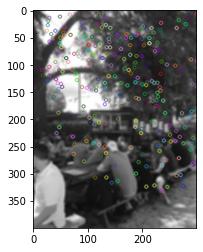

Descripteurs :  (500, 128)

[[ 18.  29.  27. ...   0.   0.   1.]
 [ 41.   0.   0. ...   0.   0.   0.]
 [115. 133.   2. ...   9.   1.   2.]
 ...
 [ 36.   2.   0. ...   0.   0.   0.]
 [ 51.  85.  16. ... 106.  51.  33.]
 [ 87.  31.  23. ...   0.   0.   2.]]


In [140]:
kp,des=transform_image(list_photos[0])
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [141]:
import time, cv2
sift_keypoints = []
temps1=time.time()

for image_num in range(len(list_photos)) :
    if image_num%500 == 0 : print(image_num)
    _,des=transform_image(list_photos[image_num])
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
# On aligne les 307 descripteur par image pour faire une liste unique de descripteur
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)
print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
500
1000
1500
2000

Nombre de descripteurs :  (1054393, 128)
temps de traitement SIFT descriptor :            83.17 secondes


In [142]:
sift_keypoints_by_img.shape

(2500,)

In [143]:
sift_keypoints_all.shape

(1054393, 128)

In [144]:
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  1027
Création de 1027 clusters de descripteurs ...
temps de traitement kmeans :            50.32 secondes


In [149]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%500 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
500
1000
1500
2000
temps de création histogrammes :            40.97 secondes


In [150]:
im_features.shape

(2500, 1027)

In [151]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (2500, 1027)
Dimensions dataset après réduction PCA :  (2500, 927)


In [152]:
feat_pca

array([[-1.04553831e-02, -1.68868147e-03,  1.67134899e-03, ...,
        -4.73101620e-04,  4.13759248e-04, -6.48744216e-04],
       [-7.47086151e-03, -2.92887118e-03,  3.94677927e-07, ...,
         4.58340672e-04, -3.55184497e-04,  7.73389537e-04],
       [-9.66729391e-03,  2.54937305e-03,  2.34911164e-03, ...,
         5.59834302e-04, -5.60152382e-04, -5.00198332e-05],
       ...,
       [-9.91472383e-03, -2.35832275e-03,  1.97387583e-03, ...,
         1.01664607e-04,  6.82023153e-04,  5.11325975e-04],
       [-4.92578739e-03, -3.64203026e-03, -1.19245071e-03, ...,
        -2.01510387e-05,  7.93183048e-04,  6.13366294e-04],
       [-1.13442350e-02, -1.24252632e-03,  2.80168574e-03, ...,
        -1.86659588e-03, -3.24783534e-04, -2.01778315e-03]])

In [156]:
final_df = pd.DataFrame(feat_pca)
final_df["label"] = label_cluster

In [157]:
final_df["label"].value_counts()

3    1812
1     353
2     286
4      44
0       5
Name: label, dtype: int64

In [159]:
final_df["true_label"] = list_label

In [160]:
final_df["true_label"].value_counts()

food        500
menu        500
drink       500
interior    500
outside     500
Name: true_label, dtype: int64

In [161]:
from sklearn.linear_model import SGDClassifier

In [162]:
y = final_df["true_label"]
X = final_df.drop(["true_label","label"],axis=1)

In [163]:
model = SGDClassifier().fit(X,y)

In [164]:
y_pred = model.predict(X)

In [172]:
final_df["label_pred"] = y_pred

In [184]:
final_df["label_pred"].value_counts()

menu        1471
food         538
interior     268
outside      202
drink         21
Name: label_pred, dtype: int64

In [182]:
true_label = final_df["true_label"].value_counts().index.tolist()
pred_label = final_df["label_pred"].value_counts().index.tolist()

In [166]:
conf_mat = metrics.confusion_matrix(y, y_pred)
print(conf_mat)

[[ 20 127  62 236  55]
 [  0 345  14 126  15]
 [  0  31 168 273  28]
 [  0   1   1 496   2]
 [  1  34  23 340 102]]


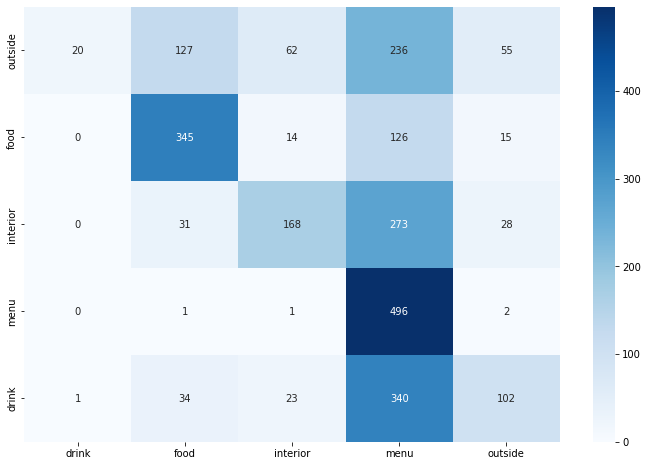

In [190]:
df_cm = pd.DataFrame(conf_mat, index = ["outside","food","interior","menu","drink"],
                  columns = ["drink","food","interior","menu","outside"])
plt.figure(figsize = (12,8))
sns.heatmap(df_cm, annot=True,fmt="d", cmap="Blues")
plt.show()

In [170]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

       drink       0.95      0.04      0.08       500
        food       0.64      0.69      0.66       500
    interior       0.63      0.34      0.44       500
        menu       0.34      0.99      0.50       500
     outside       0.50      0.20      0.29       500

    accuracy                           0.45      2500
   macro avg       0.61      0.45      0.39      2500
weighted avg       0.61      0.45      0.39      2500



Avec cette approche le résutlat est cohérent avec notre première analyse, le menu semblent pouvoir être mieux distinguée que les autre classe à basse dimension, mais ici le classifier (non optimisé) classifie trop d'image comme des "menu"

In [192]:
print("ARI : ", metrics.adjusted_rand_score(y, y_pred))

ARI :  0.12784136814147018


In [194]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = final_df["true_label"]
print(df_tsne.shape)

(2500, 3)


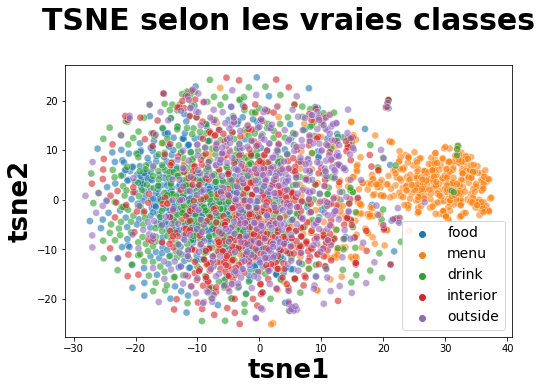

In [195]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

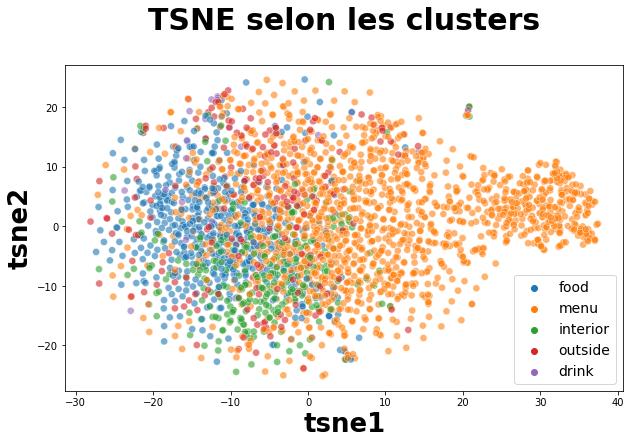

In [198]:
df_tsne["prediction"] = final_df["label_pred"].values

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="prediction",
    palette=sns.color_palette('tab10', n_colors=n_cluster), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# Approche Deep Learning / CNN (transfer learning et "from scratch")

## Transfert learning avec VGG16 "imagenet"

In [17]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense
from keras import Model
import tensorflow as tf

input_shape = (224,224,3)
vgg16 = VGG16(weights="imagenet",include_top=False,input_shape=input_shape,classes=5)
vgg16.summary()

In [149]:
for layer in vgg16.layers: 
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')

Layer input_7 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [151]:
last = vgg16.layers[-1].output
x = Flatten()(last)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(5, activation='softmax', name='predictions')(x)

# Définir le nouveau modèle
model = Model(vgg16.input, x)

In [152]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
from keras.preprocessing import image as p_img

2021-10-18 12:52:00.199513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-18 12:52:00.199561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [40]:
list_photos = []
list_label = []
for name in list_labels :
    sample_df = list_photos_by_label_name(final_df_photos,name,500)
    list_photos.extend(sample_df["photo"].tolist())
    list_label.extend(sample_df["label"].tolist())

In [41]:
list_labels

['food', 'menu', 'drink', 'interior', 'outside']

In [42]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as p_img

def preprocess_img(path):
    return p_img.img_to_array(p_img.load_img(path,target_size=(224,224)))

def get_image_preprocess(path):
    return preprocess_input(p_img.img_to_array(p_img.load_img(path,target_size=(224,224))))

def preprocess_label(label):
    dic = {
        "food":0,
        "menu":1,
        "drink":2,
        "interior":3,
        "outside":4
    }
    return dic[label]

def get_label(neurone_i):
    dic = {
        0:"food",
        1:"menu",
        2:"drink",
        3:"interior",
        4:"outside"
    }
    return dic[neurone_i]

def get_classement(pred):
    for i in prediction.argsort()[0][::-1]:
        print("#"+str(get_label(i)),":",str(round(prediction[0][i]*100,2))+"%")

In [29]:
%%time
X = np.asarray([preprocess_img(path) for path in list_photos])
y = np.asarray([preprocess_label(label) for label in list_label])
# y = np.asarray(list_label)
X=np.asarray([preprocess_input(img_ar) for img_ar in X])

CPU times: user 9.13 s, sys: 1.4 s, total: 10.5 s
Wall time: 15.8 s


In [43]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [158]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model.fit(X_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
8/8 [==============================] - 37s 4s/step - loss: 15.4505 - accuracy: 0.6290
Epoch 2/10
8/8 [==============================] - 37s 5s/step - loss: 0.7329 - accuracy: 0.8625
Epoch 3/10
8/8 [==============================] - 36s 5s/step - loss: 0.3040 - accuracy: 0.8875
Epoch 4/10
8/8 [==============================] - 36s 4s/step - loss: 0.2323 - accuracy: 0.9140
Epoch 5/10
8/8 [==============================] - 36s 4s/step - loss: 0.1553 - accuracy: 0.9265
Epoch 6/10
8/8 [==============================] - 36s 4s/step - loss: 0.1322 - accuracy: 0.9420
Epoch 7/10
8/8 [==============================] - 36s 5s/step - loss: 0.1195 - accuracy: 0.9425
Epoch 8/10
8/8 [==============================] - 37s 5s/step - loss: 0.1147 - accuracy: 0.9535
Epoch 9/10
8/8 [==============================] - 37s 5s/step - loss: 0.1025 - accuracy: 0.9625
Epoch 10/10
8/8 [==============================] - 36s 5s/step - loss: 0.0704 - accuracy: 0.9705


In [160]:
# We evaluate the accuracy and the loss in the test set
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

16/16 [==============================] - 12s 712ms/step - loss: 0.6382 - accuracy: 0.9040
Test loss: 0.6381925344467163
Test accuracy: 0.9039999842643738


In [36]:
predictions = transfert.predict_generator(X_test)
predicted_classes = np.argmax(predictions, axis=1)

In [44]:
true_classes = np.argmax(y_test,axis=1) 

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_classes,predicted_classes)

In [50]:
pd.DataFrame(cm,columns=list_labels,index=list_labels)

,food,menu,drink,interior,outside
food,87,0,10,2,1
menu,1,83,1,3,0
drink,3,0,102,1,2
interior,2,2,2,97,8
outside,0,1,2,7,83


On obtien ici une accuracy de 90% avec seulement 400 images par labels et seulement 10 epochs en 5 minutes seulement!

In [161]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Prédiction simple

outside


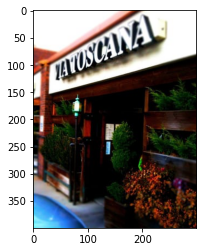

In [224]:
photo_n= 120001
path = final_df_photos.iloc[photo_n]["photo"]
label = final_df_photos.iloc[photo_n]["label"]
image = get_image_preprocess(path)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print(label)
img = plt.imread(path)
plt.imshow(img)
plt.show()

In [225]:
prediction = model.predict(image)
label = prediction.argsort()[0][4]
label = get_label(label)
print("Prediction :",label)
print("Classement :")
get_classement(prediction)

Prediction : outside
Classement :
#outside : 100.0%
#interior : 0.0%
#drink : 0.0%
#food : 0.0%
#menu : 0.0%


In [247]:
model.save("./data/model/vgg16_transfert_learning")

INFO:tensorflow:Assets written to: ./data/model/vgg16_transfert_learning/assets


## CNN manuel ("from scratch")

In [199]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [240]:
classifier = Sequential()

In [241]:
# CNN:
# 1.0) Convolution
classifier.add(Convolution2D(filters=64,
                             kernel_size=3,
                             strides=1,
                             input_shape=(224,224,3),
                             activation="relu"))
# 2.0) Pooling
classifier.add(MaxPooling2D(pool_size=(2,2),
                            strides=None))

# 1.1) Convolution
classifier.add(Convolution2D(filters=32,
                             kernel_size=3,
                             strides=1,
                             activation="relu"))
# 2.1) Pooling
classifier.add(MaxPooling2D(pool_size=(2,2),
                            strides=None))

# 3) Flattening
classifier.add(Flatten())

# CNN - ANN :
# 4) Fully connected
classifier.add(Dense(units=128,activation="relu",name='fully_connected'))

# 5) Output
classifier.add(Dense(units=5,activation="softmax", name='predictions'))

In [242]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [243]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 32)      18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 93312)             0         
_________________________________________________________________
fully_connected (Dense)      (None, 128)               11944064  
_________________________________________________________________
predictions (Dense)          (None, 5)                

In [8]:
list_photos = []
list_label = []
for name in list_labels :
    sample_df = list_photos_by_label_name(final_df_photos,name,1000)
    list_photos.extend(sample_df["photo"].tolist())
    list_label.extend(sample_df["label"].tolist())

In [9]:
%%time
X = np.asarray([preprocess_img(path) for path in list_photos])
y = np.asarray([preprocess_label(label) for label in list_label])
# y = np.asarray(list_label)
X=np.asarray([preprocess_input(img_ar) for img_ar in X])

NameError: name 'preprocess_img' is not defined

In [232]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [244]:
# Entraîner sur les données d'entraînement (X_train, y_train)
classifier.fit(X_train, y_train, epochs=10, batch_size=256)

Epoch 1/10
16/16 [==============================] - 63s 4s/step - loss: 393.9072 - accuracy: 0.3052
Epoch 2/10
16/16 [==============================] - 67s 4s/step - loss: 1.7079 - accuracy: 0.2270
Epoch 3/10
16/16 [==============================] - 69s 4s/step - loss: 1.5962 - accuracy: 0.2368
Epoch 4/10
16/16 [==============================] - 62s 4s/step - loss: 1.5796 - accuracy: 0.2735
Epoch 5/10
16/16 [==============================] - 66s 4s/step - loss: 1.5691 - accuracy: 0.3320
Epoch 6/10
16/16 [==============================] - 63s 4s/step - loss: 1.5527 - accuracy: 0.3313
Epoch 7/10
16/16 [==============================] - 63s 4s/step - loss: 1.5295 - accuracy: 0.3685
Epoch 8/10
16/16 [==============================] - 63s 4s/step - loss: 1.4927 - accuracy: 0.4248
Epoch 9/10
16/16 [==============================] - 70s 4s/step - loss: 1.4362 - accuracy: 0.4678
Epoch 10/10
16/16 [==============================] - 69s 4s/step - loss: 1.3525 - accuracy: 0.4975


In [245]:
# We evaluate the accuracy and the loss in the test set
scores = classifier.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

32/32 [==============================] - 3s 79ms/step - loss: 1.6134 - accuracy: 0.2960
Test loss: 1.613356351852417
Test accuracy: 0.29600000381469727


ici le résultat est assez peu performant, il serais nécessaire de passer plus de temps pour optimiser l'algorithme et lui faire passer plus de données pour obtenir un résutltat simmillaire ou meilleur que le transfert learning.

In [246]:
classifier.save("./data/model/classifier_from_scratch")

2021-10-12 13:29:00.463054: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./data/model/classifier_from_scratch/assets


In [19]:
import tensorflow as tf
from tensorflow import keras
transfert = keras.models.load_model('./data/model/vgg16_transfert_learning')
from_scratch = keras.models.load_model('./data/model/classifier_from_scratch')

In [17]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image as p_img
def preprocess_img(path):
    return p_img.img_to_array(p_img.load_img(path,target_size=(224,224)))

def get_image_preprocess(path):
    return preprocess_input(p_img.img_to_array(p_img.load_img(path,target_size=(224,224))))

def preprocess_label(label):
    dic = {
        "food":0,
        "menu":1,
        "drink":2,
        "interior":3,
        "outside":4
    }
    return dic[label]

def get_label(neurone_i):
    dic = {
        0:"food",
        1:"menu",
        2:"drink",
        3:"interior",
        4:"outside"
    }
    return dic[neurone_i]

def get_classement(pred):
    for i in prediction.argsort()[0][::-1]:
        print("#"+str(get_label(i)),":",str(round(prediction[0][i]*100,2))+"%")

interior


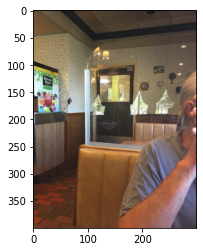

In [20]:
photo_n= 84908
path = final_df_photos.iloc[photo_n]["photo"]
label = final_df_photos.iloc[photo_n]["label"]
image = get_image_preprocess(path)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print(label)
img = plt.imread(path)
plt.imshow(img)
plt.show()

In [21]:
prediction = transfert.predict(image)
label = prediction.argsort()[0][4]
label = get_label(label)
print("Prediction :",label)
print("Classement :")
get_classement(prediction)

Prediction : interior
Classement :
#interior : 100.0%
#outside : 0.0%
#food : 0.0%
#drink : 0.0%
#menu : 0.0%


In [37]:
prediction = from_scratch.predict(image)
label = prediction.argsort()[0][4]
label = get_label(label)
print("Prediction :",label)
print("Classement :")
get_classement(prediction)

Prediction : food
Classement :
#food : 23.46%
#drink : 22.32%
#interior : 19.57%
#menu : 17.54%
#outside : 17.11%
